In [1]:
import sys
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from shapely.ops import unary_union

sys.path.append(str(Path.cwd()))
sys.path.append(str(Path.cwd().parent/'scripts'))

from _helpers import generate_color_list
from industry_cluster_analysis import (
    get_costoptimal_network,
    get_simple_costoptimal_network,
    get_partitions,
    plot_network,
    # get_plant_capex,
    get_heat_network,
    coords_to_relative_utm,
    cluster_points,
    round_borehole_capex,
)

In [2]:
from scipy.spatial.distance import pdist

points = np.random.uniform(size=(100, 2))

clusters = cluster_points(points, list(range(len(points))), 0.2)

0 0.19772376335337466
1 0.07168330105830452
2 0.0944575621362953
3 0.13353720517590584
4 0.08707169910374743
5 0.011685520386527657
6 0.14364469328956644
7 0.08770145503435045
8 0.15539303460465978
9 0.1508607780095089
10 0.19060091366762755
11 0.14098280212836636
12 0.17007220370977746
13 0.1721604796248673
14 0.07093863088273882
15 0.08416206325035017
16 0.11682946118008165
17 0.10146309331185818
18 0.19464155676281175
19 0.17858604710400877
20 0.08577313112850188
22 0.1062432411940532
23 0.19829699026825878
24 0.15741893490374986
25 0.07144070042683501
26 0.0762824908453435


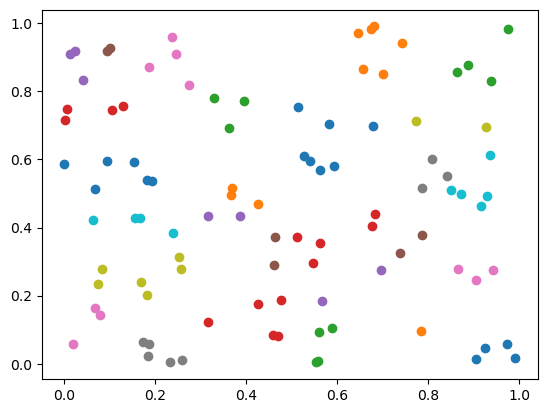

In [3]:

fig, ax = plt.subplots()   
for i, c in enumerate(clusters):
    # print(c)
    # print(points[c,:])

    if len(c) > 1:
        print(i, pdist(points[c,:]).max())
    
    ax.scatter(points[c,0], points[c,1])

plt.show()

In [4]:
'''
n = 100
pipe_capex = 1000

sample_coords = np.hstack((
    np.random.uniform(-101, -100, (n, 1)),
    np.random.uniform(38, 39, (n, 1)),
))

sample_coords_meters = coords_to_relative_utm(sample_coords)

sample_temps = np.random.uniform(80, 250, n).tolist()
sample_caps = np.random.uniform(1, 5, n).tolist()

# sample_network, sample_cost = get_costoptimal_network(sample_coords, sample_temps, sample_caps)
T, sample_cost = get_simple_costoptimal_network(
    sample_coords_meters,
    pipe_capex=pipe_capex,
    # sample_temps,
    # sample_caps,
    )

base = nx.Graph()
for i, (x, y) in enumerate(sample_coords_meters):
    base.add_node(
        i,
        pos=(x, y),
        )


for i, j in product(range(n), range(n)):
    if i > j:
        base.add_edge(i, j, weight=np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j])))

tree = nx.minimum_spanning_tree(base, weight='weight', algorithm='kruskal')

salesman = nx.Graph()
# for i, (x, y) in enumerate(sample_coords):
for i, (x, y) in enumerate(sample_coords_meters):
    salesman.add_node(
        i,
        pos=(x, y),
        )

edgelist = nx.to_pandas_edgelist(T)
print(edgelist)

for i, j in edgelist[['source', 'target']].values:
    # length = V_inv(np.array(sample_coords[i]), np.array(sample_coords[j]))[0]
    salesman.add_edge(i, j, weight=np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j])))
        # 4 because there is a hot and cold cycle

    # T = nx.minimum_spanning_tree(G, weight='weight', algorithm='kruskal')
plot_network(tree, sample_coords_meters, sample_caps, sample_temps)
plot_network(salesman, sample_coords_meters, sample_caps, sample_temps)

total_length_salesman = 0
for i, j in salesman.edges:
    total_length_salesman += np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j]))

total_length_tree = 0
for i, j in tree.edges:
    total_length_tree += np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j]))

print(total_length_salesman, total_length_tree)
'''

"\nn = 100\npipe_capex = 1000\n\nsample_coords = np.hstack((\n    np.random.uniform(-101, -100, (n, 1)),\n    np.random.uniform(38, 39, (n, 1)),\n))\n\nsample_coords_meters = coords_to_relative_utm(sample_coords)\n\nsample_temps = np.random.uniform(80, 250, n).tolist()\nsample_caps = np.random.uniform(1, 5, n).tolist()\n\n# sample_network, sample_cost = get_costoptimal_network(sample_coords, sample_temps, sample_caps)\nT, sample_cost = get_simple_costoptimal_network(\n    sample_coords_meters,\n    pipe_capex=pipe_capex,\n    # sample_temps,\n    # sample_caps,\n    )\n\nbase = nx.Graph()\nfor i, (x, y) in enumerate(sample_coords_meters):\n    base.add_node(\n        i,\n        pos=(x, y),\n        )\n\n\nfor i, j in product(range(n), range(n)):\n    if i > j:\n        base.add_edge(i, j, weight=np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j])))\n\ntree = nx.minimum_spanning_tree(base, weight='weight', algorithm='kruskal')\n\nsalesman = nx.Graph()\n

In [5]:
shape = gpd.read_file(Path.cwd() /
        'misc_data' /
        'zip_data' /
        'backup_copy' /
        'resources' /
        'US_2021' /
        'bus_regions' /
        'regions_onshore_elec_s_100flex.geojson' /
        'regions_onshore_elec_s_100flex.geojson'
        )

usa_total = gpd.GeoDataFrame(geometry=[unary_union(shape['geometry'])]).set_crs(shape.crs)

In [6]:
def get_dummy_data(do_plot=False):

    n = 500

    t_levels = [90 + i*5 for i in range(40)]

    sites = gpd.GeoDataFrame(
        {
            'demand': np.random.uniform(1, 10, n),
            'temperature': np.random.choice(t_levels, n, replace=True)
            },
        geometry=gpd.points_from_xy(
            # np.random.uniform(-130, -60, 1000),
            # np.random.uniform(25, 50, 1000)
            np.random.uniform(-130, -120, n),
            np.random.uniform(40, 45, n)
            )
        ).set_crs(epsg=4326)

    sites['demand'] *= 50_000

    sites = sites.sjoin(shape, how='inner')

    if do_plot:

        fig, ax = plt.subplots(figsize=(7, 7))

        shape.plot(ax=ax)
        sites.plot(
            ax=ax,
            # color='red',
            column='temperature',
            cmap='magma',
            edgecolor='black',
            markersize=40
            )

        cax = fig.add_axes([0.9, 0.1, 0.03, 0.78])

        norm = plt.Normalize(vmin=sites['temperature'].min(), vmax=sites['temperature'].max())
        sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
        fig.colorbar(sm, cax=cax)
        cax.set_ylabel('Temperature (°C)')

        ax.set_xlim(-127, -118)
        ax.set_ylim(39, 46)

        plt.show()

    return sites

In [7]:
def get_india_data():

    # df = gpd.read_file('overture_places_heating_demand_disagg_20241008.gpkg')
    df = gpd.read_file('overture_places_heating_demand_disagg_wp_filtered_20241020.gpkg')

    id_cols = [
        'names_primary', 'geometry',
        'industrial_type', 'industrial_sub_type'
    ]

    heating_cols = [
        col for col in df.columns
        if 'Heating (BBtu)' in col and 'total' not in col and '<250' not in col
    ]

    # Melt the dataframe to unpivot heating columns
    df_melted = df.melt(
        id_vars=id_cols,
        value_vars=heating_cols,
        var_name='Temperature Range',
        value_name='Heating Demand (BBtu)'
    )

    # Keep only rows with non-zero heating demand
    df_melted = df_melted[df_melted['Heating Demand (BBtu)'] != 0]

    # Clean up the 'Temperature Range' column
    df_melted['Temperature Range'] = df_melted['Temperature Range'].str.replace(
        'Heating (BBtu), ', '', regex=False
    )

    # Convert BBtu to MWh (1 BBtu = 293.07107 MWh)
    df_melted['Heating Demand (MWh)'] = df_melted['Heating Demand (BBtu)'] * 293.07107

    # Optionally drop the original 'Heating Demand (BBtu)' column
    df_melted = df_melted.drop(columns=['Heating Demand (BBtu)'])

    # Reorder columns if necessary
    df_melted = df_melted[
        id_cols + ['Temperature Range', 'Heating Demand (MWh)']
    ]

    # Cut off rows with heating demand above a certain threshold 
    cutoff = 5000 # MWh; cutoff of 5GWh removes around 1% of total demand, and 50% of datapoints
    # df_melted = df_melted.loc[df_melted['Heating Demand (MWh)'] > cutoff]
    df_melted = df_melted.loc[df_melted['Heating Demand (MWh)'] > cutoff]

    df_melted = df_melted.reset_index(drop=True)

    temp_mapper = {
        '0 to 49°C': 50,
        '50 to 99°C': 100,
        '100 to 149°C': 150,
        '150 to 199°C': 200,
        '200 to 249°C': 250,
        '250 to 299°C': 300,
        '300 to 349°C': 350,
        '350 to 399°C': 400,
        '400 to 449°C': 450,
        '>450°C': 500,
    }

    for old, new in temp_mapper.items():
        df_melted.replace(old, new, inplace=True)
    df_melted.rename(columns={
        'Temperature Range': 'temperature',
        'Heating Demand (MWh)': 'total_demand',
        }, inplace=True)
    df_melted['avg_demand'] = df_melted['total_demand'] / 8760

    df_melted = df_melted.loc[df_melted['temperature'] <= 250]
    # df_melted = df_melted.loc[df_melted['temperature'] < 400]

    df_melted['x'] = df_melted['geometry'].x
    df_melted['y'] = df_melted['geometry'].y

    return df_melted


In [8]:
# get_dummy_data().columns
sites = get_india_data()

C:\Users\lukas\AppData\Local\Temp\ipykernel_23168\1968025829.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_melted.replace(old, new, inplace=True)


In [9]:
print(sites.shape)
sites.loc[sites['avg_demand'] > 10].shape

(1956, 9)


(371, 9)

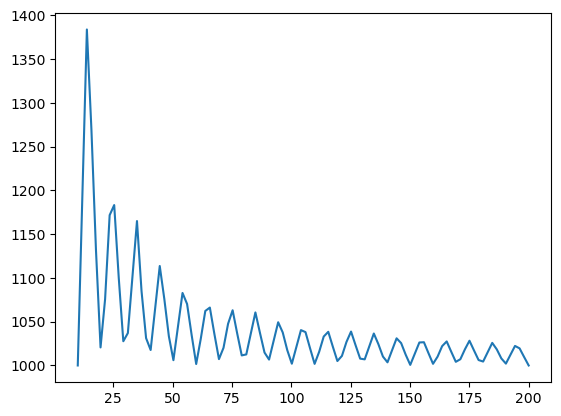

In [10]:
# def round_borehole_capex(cap, one_drill_cap, one_drill_capex):
# 
#     fraction = cap / one_drill_cap
#     n_wells = round(fraction)
# 
#     return one_drill_capex * max(n_wells, fraction) / min(n_wells, fraction)

caps = np.linspace(10, 200, 100)

plt.plot(
    caps,
    [round_borehole_capex(cap, 10, 1_000_000) / 1000 for cap in caps]
    )

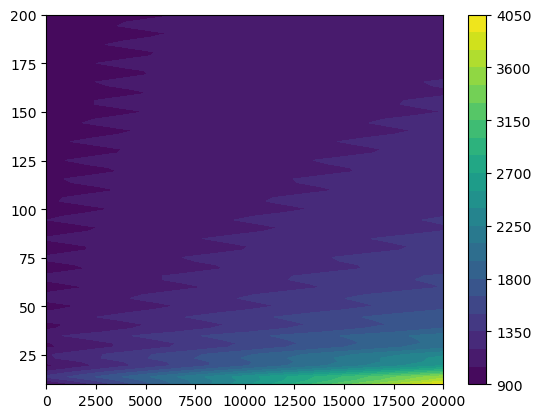

In [11]:
lengths = np.linspace(0, 20_000, 200)

lengths_grid, caps_grid = np.meshgrid(lengths, caps)

def get_borehole_capex(length, cap, one_drill_cap, one_drill_capex):
    return round_borehole_capex(cap, one_drill_cap, one_drill_capex) + 1_500 * length / cap

z = np.array([
    [get_borehole_capex(length, cap, 10, 1_000_000) for length in lengths]
    for cap in caps
    ]) * 1e-3

cbar = plt.contourf(lengths_grid, caps_grid, z, levels=20)
plt.colorbar(cbar)

In [13]:
countries = gpd.read_file('country_shapes.geojson').set_index('cntry_name').loc[[
    'India',
    'Pakistan',
    'Bangladesh',
    'Bhutan',
    'China',
    'Sri Lanka'
    ]]

In [ ]:
import tqdm

threshold_distance_km = 20
threshold_distance_km_clustering = 8
threshold_distance_rad = threshold_distance_km / 6371.0

network_capacity_threshold = 9 # MWth
one_drill_capex = 9_200_000 / network_capacity_threshold # 9.2 million USD for 10 MWth borehole

# for index_right in sites.index_right.value_counts().index:
def cluster_sites(
        sites,
        pipe_capex_value=1500,
        do_plot=False,
        save_network_data=False,
        ):

    # ss = sites.loc[sites.index_right == index_right]
    ss = sites.copy()

    sites_np = np.array([ss['geometry'].y, ss['geometry'].x]).T

    db = DBSCAN(
        eps=threshold_distance_rad,
        min_samples=2,
        metric='haversine').fit(np.radians(sites_np))
        # metric='haversine').fit(np.radians(sites_np_meters))
        # ).fit(np.radians(sites_np_meters))

    labels = db.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    sites['cluster'] = labels
    sites['cluster_size'] = list(map(pd.Series(labels).value_counts().get, labels))

    max_cluster_size = 10000
    
    if do_plot:
        _, ax = plt.subplots(1, 1, figsize=(10, 8))
    # shape.plot(ax=ax)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    caps, capex, cluster_size = [], [], []

    cluster_counter = 0
    save_locs_x, save_locs_y, save_sizes = [], [], []
    save_temps, save_cluster, save_costs = [], [], []

    for k, col in tqdm.tqdm(zip(unique_labels, colors)):

        class_member_mask = (labels == k)
        # print(class_member_mask.sum())

        if max_cluster_size is not None:
            if k != -1 and class_member_mask.sum() > max_cluster_size:
                continue

        xy = sites_np[class_member_mask]
        xy_meters = coords_to_relative_utm(xy)

        size = ss.iloc[class_member_mask]['avg_demand']
        temps = ss.iloc[class_member_mask]['temperature']

        if sum(size) < network_capacity_threshold:
            continue

        if k == -1:
            col = [0, 0, 0, 1]

            for s, n_xy, t in zip(size, xy, temps):
                if s < network_capacity_threshold:
                    continue
                else:

                    caps.append(s)

                    plant_capex = (
                        round_borehole_capex(
                            s,
                            network_capacity_threshold,
                            one_drill_capex
                            )
                    )
                    capex.append(plant_capex)
                    cluster_size.append(1)

                    save_locs_x.append(n_xy[1])
                    save_locs_y.append(n_xy[0])
                    save_sizes.append(s)
                    save_temps.append(t)
                    save_cluster.append(cluster_counter)
                    cluster_counter += 1

        else:
            # partitions = get_partitions(list(range(len(xy))))
            # partitions = [[tuple(range(len(xy)))]]
            partitions = [
                cluster_points(
                    xy_meters * 1e-3,
                    range(len(xy)),
                    threshold_distance_km
                    )
                ]
            
            assert len(partitions) == 1

            partition_costs = []
            disagg_partition_costs = []

            partition_caps = []
            partition_cluster_sizes = []

            for i, partition in enumerate(partitions):

                n_cost = []
                n_caps = []
                n_cluster_size = []

                for n_idx in partition:

                    n_size = size.iloc[list(n_idx)]
                    if sum(n_size) < network_capacity_threshold:
                        continue

                    n_xy = xy[[n_idx]][0]
                    n_xy_meters = xy_meters[[n_idx]][0]
                    n_temp = temps.iloc[list(n_idx)].tolist()
                    n_cluster_size.append(len(n_idx))

                    save_locs_x.extend(n_xy[:, 1])
                    save_locs_y.extend(n_xy[:, 0])
                    save_sizes.extend(n_size)
                    save_temps.extend(n_temp)
                    save_cluster.extend([cluster_counter] * len(n_size))
                    cluster_counter += 1

                    total_caps, total_cost = get_heat_network(
                        # n_xy,
                        n_xy_meters,
                        n_temp,
                        n_size,
                        network_capacity_threshold,
                        one_drill_capex,
                        pipe_capex=pipe_capex_value
                        )
                    # _, total_cost = get_simple_costoptimal_network(n_xy_meters)

                    total_cost += round_borehole_capex(
                        sum(n_size),
                        network_capacity_threshold,
                        one_drill_capex
                        )

                    n_cost.append(total_cost)
                    n_caps.append(sum(n_size))

                partition_costs.append(sum(n_cost))
                disagg_partition_costs.append(n_cost)
                partition_caps.append(n_caps)
                partition_cluster_sizes.append(n_cluster_size)

            if not len(partition_caps):
                continue

            best_partition = partitions[np.argmin(partition_costs)]
            best_partition_caps = partition_caps[np.argmin(partition_costs)]
            best_disagg_partition_costs = disagg_partition_costs[np.argmin(partition_costs)]
            best_partition_cluster_sizes = partition_cluster_sizes[np.argmin(partition_costs)]

            for ca, co, cl in zip(
                best_partition_caps,
                best_disagg_partition_costs,
                best_partition_cluster_sizes
                ):

                caps.append(ca)
                capex.append(co)
                cluster_size.append(cl)

        if do_plot:
            ax.scatter(
                xy[:, 1],
                xy[:, 0],
                color=tuple(col),
                edgecolor='k',
                alpha=0.7,
                s=size*10*0.5
                )


    if save_network_data:
        gdf = gpd.GeoDataFrame({
            # 'locs_x': save_locs_x,
            # 'locs_y': save_locs_y,
            'sizes': save_sizes,
            'temps': save_temps,
            'cluster': save_cluster,
            'geometry': gpd.points_from_xy(save_locs_x, save_locs_y)
            })
        gdf.dropna().set_crs(epsg=4326).to_file(save_network_data, driver='GeoJSON')

    if do_plot:
        countries.plot(ax=ax, color='none', edgecolor='black', linewidth=1, zorder=0)
        countries.loc[['India']].plot(ax=ax, color='grey', edgecolor='black', linewidth=0, zorder=0, alpha=0.2)

        ax.set_title(f'Estimated number of clusters: {n_clusters}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        # ax.set_xlim(xy[:, 1].min() - 0.1, xy[:, 1].max() + 0.1)
        # ax.set_ylim(xy[:, 0].min() - 0.1, xy[:, 0].max() + 0.1)

        ax.set_xlim(67, 97)
        ax.set_ylim(7.2, 35.1)

        plt.show()

    return pd.DataFrame({
        'caps': caps,
        'capex': capex,
        'cluster_size': cluster_size
        }).dropna()


219it [00:03, 66.08it/s]


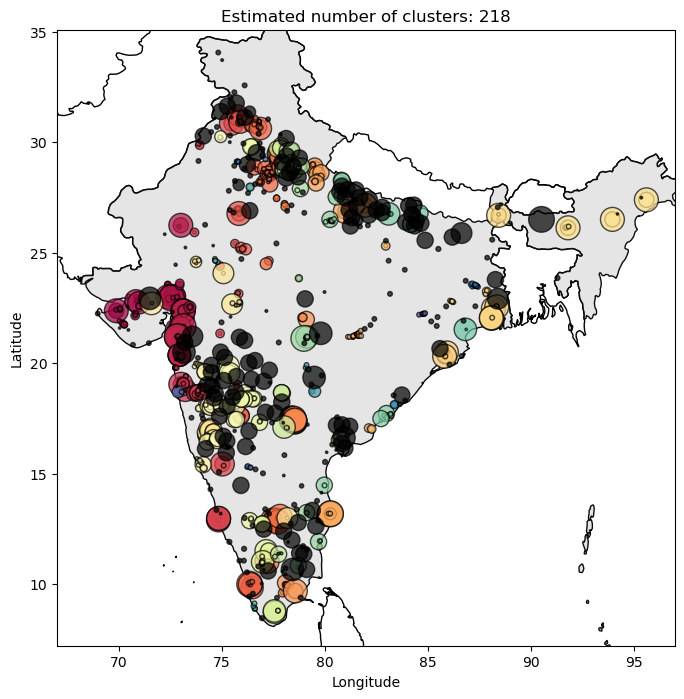

219it [00:03, 59.84it/s]


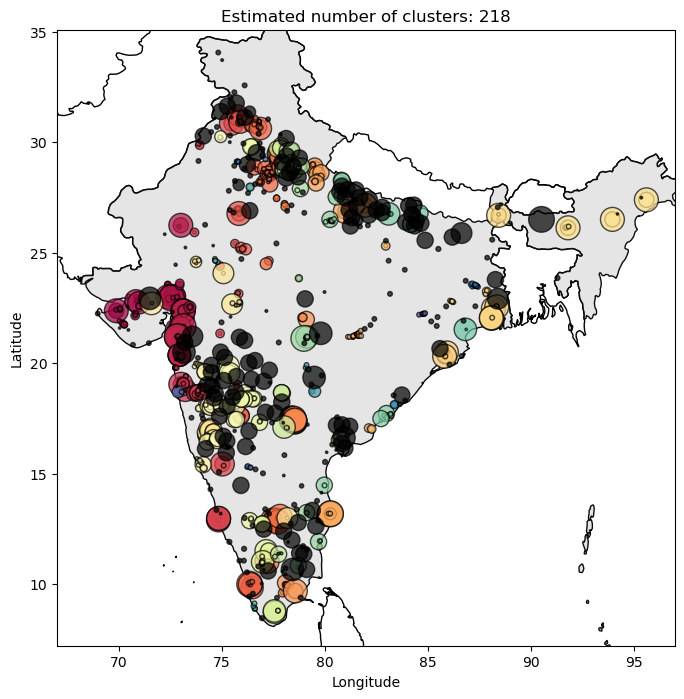

219it [00:03, 67.10it/s] 


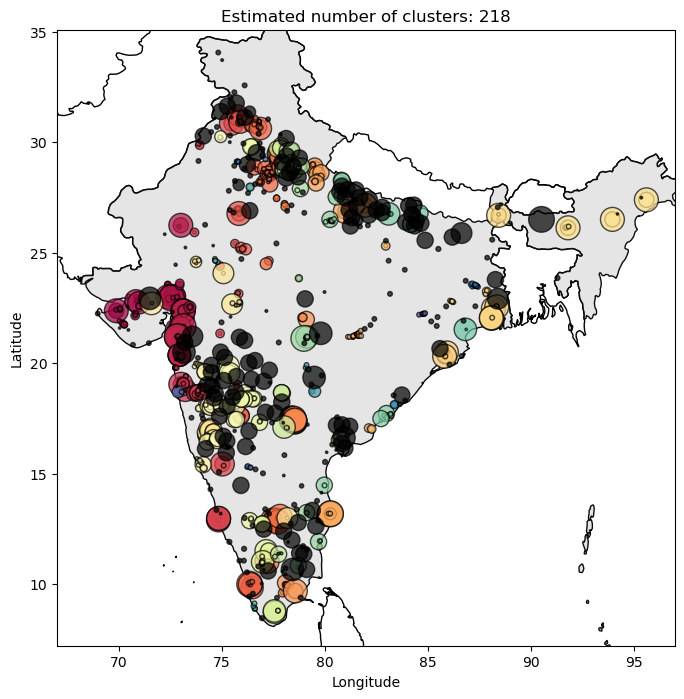

In [16]:
data = list()
for i, capex in enumerate([1000, 1500, 2000]):

    region_df = cluster_sites(
        sites,
        pipe_capex_value=capex,
        do_plot=True,
        save_network_data=f'network_clustering_layout.geojson'
        ).sort_values('capex')

    data.append(region_df)

In [19]:
def generate_color_list(n):
    # Use a colormap to generate n distinct colors
    cmap = plt.get_cmap('Accent')
    colors = [cmap(i / n) for i in range(n)]
    return colors

C:\Users\lukas\AppData\Local\Temp\ipykernel_15328\2333303189.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['cumcap'] = region_df['caps'].cumsum()


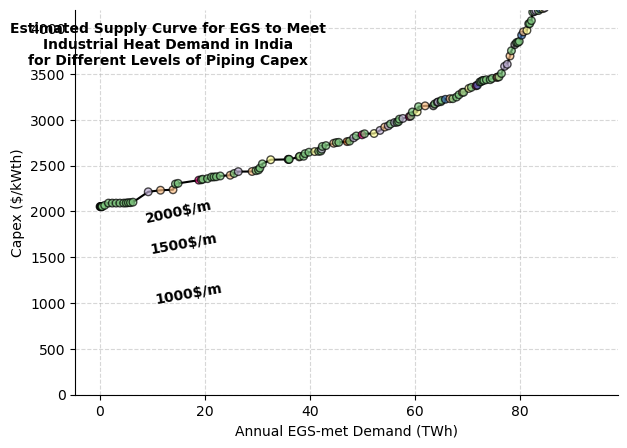

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))


for i, region_df in enumerate(data):

    region_df = region_df.loc[region_df['cluster_size'] > 1]

    # region_df = cluster_sites(sites).sort_values('capex')
    region_df['cumcap'] = region_df['caps'].cumsum()


    ax.plot(region_df['cumcap']*8760*1e-6, region_df['capex']*1e-3, zorder=1, color='black')

    color_list = generate_color_list(max(region_df['cluster_size']) + 1)
    c = [color_list[i] for i in region_df['cluster_size']]

    ax.scatter(
        region_df['cumcap']*8760*1e-6,
        region_df['capex']*1e-3,
        c=c,
        s=30,
        edgecolor='k',
        zorder=2,
        alpha=0.7
        )
    ax.set_xlabel('Annual EGS-met Demand (TWh)')
    ax.set_ylabel('Capex ($/kWth)')

    # ax.set_xlim(-10, 770)
    # ax.set_ylim(500, 1040)

    ax.grid(True, linestyle='--', alpha=0.5)

    labels = region_df['cluster_size'].unique()
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_list[i], markersize=7,
                markeredgecolor='k', label=f'{i} sites')
            for i in labels]
    
    labels = pd.DataFrame({
        'labels': labels,
        'handles': handles
        }).sort_values('labels')

    # if i == 0:
        # ax.legend(labels['handles'], labels['labels'], title='Cluster Size', loc='upper left')

# ax.text()
# rotation=slope_1000,
ax.text(15, 2000, '2000$/m', color='k', rotation=12, va='center', ha='center', fontweight='bold')
ax.text(16, 1650, '1500$/m', color='k', rotation=10, va='center', ha='center', fontweight='bold')
ax.text(17, 1100, '1000$/m', color='k', rotation=10, va='center', ha='center', fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(
    13, 3600,
    'Estimated Supply Curve for EGS to Meet\nIndustrial Heat Demand in India\nfor Different Levels of Piping Capex',
    fontsize=10,
    fontweight='bold',
    ha='center'
)

ax.set_ylim(0, 4200)

plt.show()

In [51]:
hp = { # DEA
    'capex': 1_050_000 * 1.07, # USD/MWth
    # 'VOM': 3 * 1.29,       # USD/MWhth
    'VOM': 6 * 1000 * 0.012,       # USD/MWhth
    'efficiency': 1.5,       # per unit
}

biomass = { # DEA
    'capex': 600_000 * 1.07, # USD/MWth
    'VOM': 12 * 1.07,       # USD/MWth
    'efficiency': 0.9,       # per unit
}

hp_total = (
    (
        hp['capex'] +
        (hp['VOM']) * 8760 * 25 * 0.9) / 1000 # USD/kWth
)
biomass_total = (
    (
        biomass['capex'] +
        (biomass['VOM']) * 8760 * 25 * 0.9) / 1000 # USD/kWth
)

print(hp_total)
print(biomass_total)

15314.7
3172.764


In [91]:
hp

{'capex': 1123500.0, 'VOM': 72.0, 'efficiency': 1.5}

C:\Users\lukas\AppData\Local\Temp\ipykernel_15328\3882277750.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # You can choose any colormap you like
C:\Users\lukas\AppData\Local\Temp\ipykernel_15328\3882277750.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['cumcap'] = region_df['caps'].cumsum()
C:\Users\lukas\AppData\Local\Temp\ipykernel_15328\3882277750.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

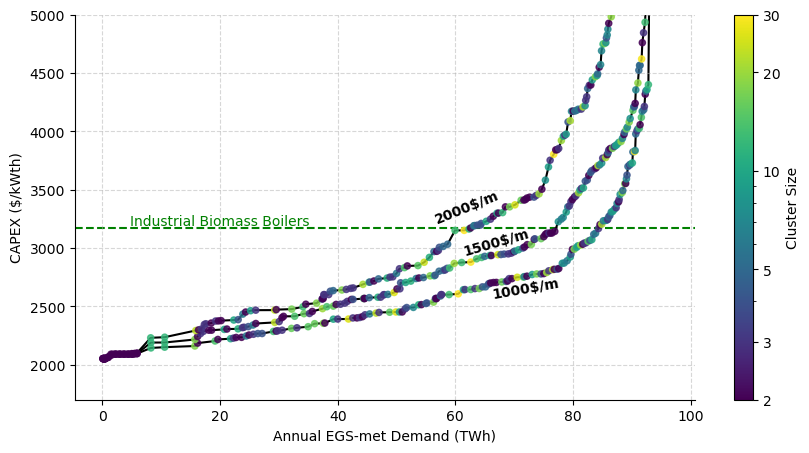

In [90]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import pandas as pd
import numpy as np

# Assume 'data' is a list of DataFrames
# Collect all cluster_size values from data to get vmin and vmax
all_cluster_sizes = pd.concat(data)['cluster_size']
min_size = 2

vmin = min_size
# vmax = all_cluster_sizes.max()
vmax = 30

# Define the colormap and normalization
cmap = cm.get_cmap('viridis')  # You can choose any colormap you like
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, region_df in enumerate(data):
    # Filter cluster_size >= 1
    region_df = region_df.loc[region_df['cluster_size'] >= min_size]
    # region_df = region_df.loc[region_df['cluster_size'] > 2]

    # Calculate cumulative capacity
    region_df['cumcap'] = region_df['caps'].cumsum()

    # Plot the line
    ax.plot(
        region_df['cumcap'] * 8760 * 1e-6,
        region_df['capex'] * 1e-3,
        zorder=1,
        color='black'
    )

    # Scatter plot with continuous color mapping
    sc = ax.scatter(
        region_df['cumcap'] * 8760 * 1e-6,
        region_df['capex'] * 1e-3,
        c=region_df['cluster_size'],
        cmap=cmap,
        norm=norm,
        s=20,
        # edgecolor='k',
        zorder=2,
        alpha=0.8
    )

    ax.set_xlabel('Annual EGS-met Demand (TWh)')
    ax.set_ylabel('CAPEX ($/kWth)')
    ax.grid(True, linestyle='--', alpha=0.5)

# Add the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cluster Size')

# Customize colorbar ticks
cbar_ticks = [vmin, 3, 5, 10, 20, vmax]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([str(int(t)) for t in cbar_ticks])

# Remove unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add text annotations
ax.text(62, 3350, '2000$/m', color='k', rotation=22, va='center', ha='center', fontweight='bold')
ax.text(67, 3050, '1500$/m', color='k', rotation=16, va='center', ha='center', fontweight='bold')
ax.text(72, 2650, '1000$/m', color='k', rotation=10, va='center', ha='center', fontweight='bold')

'''
ax.axhline(hp_total, color='red', linestyle='--', label='Heat Pump', zorder=0)
ax.text(
    20,
    hp_total+60,
    'Industrial Heat Pumps',
    color='r',
    rotation=0,
    va='center',
    ha='center',
    fontsize=10,
    )
'''
ax.axhline(biomass_total, color='green', linestyle='--', label='Heat Pump', zorder=0)
ax.text(
    20,
    biomass_total+60,
    'Industrial Biomass Boilers',
    color='green',
    rotation=0,
    va='center',
    ha='center',
    fontsize=10,
    )


'''
ax.text(
    13, 3600,
    'Estimated Supply Curve for EGS to Meet\nIndustrial Heat Demand in India\nfor Different Levels of Piping Capex',
    fontsize=10,
    fontweight='bold',
    ha='center'
)
'''

ax.set_ylim(1700, 5000)
# ax.set_xlim(0, 100)

plt.show()


In [50]:
pts = np.array([
    [28.1446, 76.8767],
    [28.6929,77.5998],
])

km = coords_to_relative_utm(pts)

pdist(km * 1e-3)

array([93.35628697])

In [52]:
import geopandas as gpd
import pandas as pd
import networkx as nx
from shapely.geometry import LineString, MultiLineString

def process_geojson(input_file, output_file):
    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(input_file)

    gdf['capex'] = np.nan

    # Project to a suitable coordinate reference system for accurate distance calculations
    gdf = gdf.to_crs(epsg=3857)

    # Initialize the 'row_type' column
    gdf['row_type'] = 'site'

    # Get unique clusters excluding -1
    clusters = gdf[gdf['cluster'] != -1]['cluster'].unique()

    for cluster_id in clusters:
        # Subset the GeoDataFrame for the current cluster
        cluster_points = gdf[gdf['cluster'] == cluster_id]
        points = list(cluster_points.geometry)
        cluster_capacity = cluster_points['sizes'].sum()

        # Create a complete graph
        G = nx.Graph()

        # Add nodes to the graph
        for idx, point in enumerate(points):
            G.add_node(idx, geometry=point)

        # Add weighted edges to the graph based on distances
        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                p1 = points[i]
                p2 = points[j]
                distance = p1.distance(p2)
                G.add_edge(i, j, weight=distance)

        # Compute the minimum spanning tree
        mst = nx.minimum_spanning_tree(G)

        # Create LineStrings for each edge in the MST
        lines = [LineString([points[u], points[v]]) for u, v in mst.edges()]
        
        pipe_length = 0
        for _, _, data in mst.edges(data=True):

            pipe_length += data['weight']

        pipe_cost = pipe_length * 1500
        plant_cost = round_borehole_capex(
            cluster_capacity,
            network_capacity_threshold,
            one_drill_capex
            )
        
        # print(pipe_cost, plant_cost)
        # print((pipe_cost + plant_cost) / 1000)
        # import sys
        # sys.exit()

        # Combine LineStrings into a MultiLineString
        mst_geometry = MultiLineString(lines)

        # Prepare a new row for the GeoDataFrame
        new_row = {
            'cluster': cluster_id,
            'geometry': mst_geometry,
            'row_type': 'network',
            'capex': (pipe_cost + plant_cost) / 1000
        }

        # Include other columns with NaN values
        for col in gdf.columns:
            if col not in new_row:
                new_row[col] = pd.NA

        # Create a new GeoDataFrame for the new row
        new_gdf = gpd.GeoDataFrame([new_row], columns=gdf.columns, crs=gdf.crs)

        # Append the new row to the original GeoDataFrame
        gdf = pd.concat([gdf, new_gdf], ignore_index=True)

    # Optionally, reproject back to the original CRS if needed
    gdf = gdf.to_crs(epsg=4326)

    gdf['egs_cost_change'] = gdf['capex'] / biomass_total

    # Save the updated GeoDataFrame to a new GeoJSON file
    gdf.to_file(output_file, driver='GeoJSON')

if __name__ == "__main__":
    input_geojson = 'network_clustering_layout.geojson'  # Replace with your input file path
    output_geojson = 'network_clustering_layout_with_pipes.geojson'  # Replace with your desired output file path
    process_geojson(input_geojson, output_geojson)


C:\Users\lukas\AppData\Local\Temp\ipykernel_23168\3826719917.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf = pd.concat([gdf, new_gdf], ignore_index=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_23168\3826719917.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf = pd.concat([gdf, new_gdf], ignore_index=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_23168\3826719917.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In 

In [53]:
a = gpd.read_file('network_clustering_layout_with_pipes.geojson')
a

,sizes,temps,cluster,capex,row_type,egs_cost_change,geometry
0,2.261383,250,0,NaN,site,NaN,POINT (70.02919 22.47342)
1,2.261383,250,0,NaN,site,NaN,POINT (70.0573 22.41347)
2,2.142426,250,0,NaN,site,NaN,POINT (70.06229 22.41872)
3,2.261383,250,0,NaN,site,NaN,POINT (70.05306 22.45596)
4,2.142426,250,0,NaN,site,NaN,POINT (70.04974 22.45918)
...,...,...,...,...,...,...,...
1698,NaN,None,297,1028.947115,network,0.324306,MULTILINESTRING EMPTY
1699,NaN,None,298,1030.120819,network,0.324676,MULTILINESTRING EMPTY
1700,NaN,None,299,1251.165583,network,0.394346,MULTILINESTRING EMPTY
1701,NaN,None,300,1251.165583,network,0.394346,MULTILINESTRING EMPTY


In [3]:

# Example usage:
if __name__ == "__main__":
    # Sample data: 2D points in kilometers
    points = np.array([
        [0, 0],
        [1, 1],
        [2, 2],
        [10, 10],
        [11, 11],
        [50, 50]
    ])
    threshold = 5  # Maximum allowable distance within a cluster

    indices = list(range(len(points)))
    clusters = cluster_points(points, indices, threshold)

    print("Clusters:")
    for cluster in clusters:
        print(cluster)


Clusters:
(0, 1, 2)
(3, 4)
(5,)


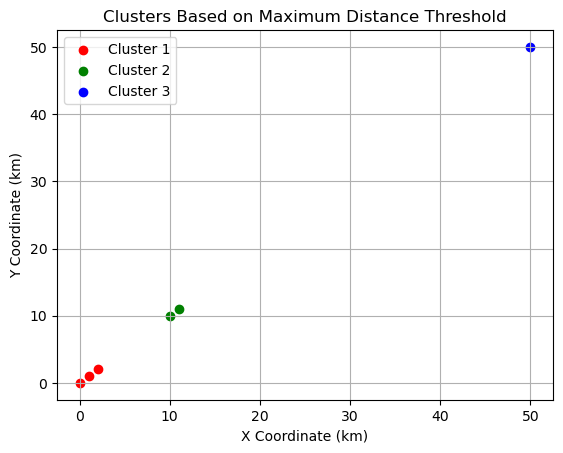

In [4]:
import matplotlib.pyplot as plt

# Plotting the clusters
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']
for i, cluster in enumerate(clusters):
    cluster_points = points[list(cluster)]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i % len(colors)], label=f'Cluster {i+1}')

plt.legend()
plt.xlabel('X Coordinate (km)')
plt.ylabel('Y Coordinate (km)')
plt.title('Clusters Based on Maximum Distance Threshold')
plt.grid(True)
plt.show()